In [1]:
import os
import numpy as np
import auditory_cortex.regression as Reg
import auditory_cortex.helpers as helpers
from transformers import Speech2TextForConditionalGeneration, Speech2TextProcessor

### Error testing part..can be removed afterwards....

### Starting pretrained networks study...

In [4]:
model = 'wave2letter_modified'
obj = Reg.transformer_regression(model, load_features=True, delay_features=True)
# obj.load_features(delay_features=True)
# aud = obj.dataset.audio(sent=12)

Loading Neural data for session: 180810 ... Done.
Creating regression obj for: 'wave2letter_modified'
Loading from checkpoint: /depot/jgmakin/data/auditory_cortex/pretrained_weights/w2l_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt
Loading ANN features at bin-width: 20
Features Delay requested: 
                   - Delaying features by half of RF for each layer 
                   - Trimming spikes by max feature delay (across all layers) 
Layer-wise delays (in samples) will be: [ 0  0  0  0  1  2  3  4  7 10] 


In [5]:
layer = 7
sent = 12
obj.sampled_features[layer][sent].shape

(59, 250)

In [4]:
session = 200206
spikes = obj.get_neural_spikes(session, sents=[12])

Loading Neural data for session: 200206 ... Done.


In [5]:
spikes.shape

(53, 64)

In [7]:
tmp = obj.sampled_features[layer][sent]
tmp.shape

(66, 250)

In [9]:
delays = np.array([0, 0, 0, 0, 1, 2, 3, 4, 7, 10, 13])
max_delay = np.max(delays)

In [12]:
layer = 0
s = tmp.shape[0]
tmp[max_delay-delays[layer] : s-delays[layer]].shape

(53, 250)

In [15]:
layer = 1
sent = 12
obj.sampled_features[layer][sent].shape

(69, 250)

In [3]:
# features = obj.unroll_features(sents=[12])

In [7]:
# features.shape

(12, 69, 250)

In [10]:
a = np.array([1.0, 2.0, 3.9, 4.0])

In [11]:
a.astype(int)

array([1, 2, 3, 4])

In [5]:
session = '200206'
bin_width = 20
delay = 0
iterations = 5
k_folds_validation = 5
N_sents = 500
use_cpu = False
corr_dict = obj.cross_validated_regression(session, bin_width=bin_width, delay=delay,
                            N=iterations, k=k_folds_validation, N_sents=N_sents,
                            return_dict=True, numpy=use_cpu)

# of iterations requested: 5, 
# of lambda samples per iteration: 20
Itr: 1:
K_fold for session: 200206
Itr: 2:
K_fold for session: 200206


KeyboardInterrupt: 

In [6]:
from IPython.display import Audio
Audio(data=aud, rate=16000)

### introducing 'features_delay' for regression computations..

### pretrained 'whisper'

In [2]:
import torch
from transformers import AutoProcessor, WhisperForConditionalGeneration
# from datasets import load_dataset

processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

In [10]:
aud = obj.dataset.audio(sent=32)
inputs = processor(aud, return_tensors="pt", sampling_rate=16000)
input_features = inputs.input_features

generated_ids = model.generate(inputs=input_features, max_new_tokens=400)

transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
transcription


' He moistened his lips uneasily.'

#### Network and hidden layers.
Whisper is transformer based network, with encoder having following architecture;
- 02 convolution layers
- 04 self attention layers  
Decoder also has 04 layers of attention.

In [28]:
dict([*model.named_modules()])['model.encoder']

WhisperEncoder(
  (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
  (embed_positions): Embedding(1500, 384)
  (layers): ModuleList(
    (0): WhisperEncoderLayer(
      (self_attn): WhisperAttention(
        (k_proj): Linear(in_features=384, out_features=384, bias=False)
        (v_proj): Linear(in_features=384, out_features=384, bias=True)
        (q_proj): Linear(in_features=384, out_features=384, bias=True)
        (out_proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (activation_fn): GELUActivation()
      (fc1): Linear(in_features=384, out_features=1536, bias=True)
      (fc2): Linear(in_features=1536, out_features=384, bias=True)
      (final_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
    (1): WhisperEncoderLayer(
      (self_attn): WhisperAttention(


In [27]:
dict([*model.named_modules()])['model.encoder.conv1']


Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))

In [25]:
dict([*model.named_modules()])['model.encoder.layers.0.final_layer_norm']

LayerNorm((384,), eps=1e-05, elementwise_affine=True)

### pretrained 'speech2text'

In [8]:
model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-large-librispeech-asr")
processor = Speech2TextProcessor.from_pretrained("facebook/s2t-large-librispeech-asr")
# model.encoder.layers.0.final_layer_norm

In [17]:
dict([*model.named_modules()])['model']

Speech2TextModel(
  (encoder): Speech2TextEncoder(
    (conv): Conv1dSubsampler(
      (conv_layers): ModuleList(
        (0): Conv1d(80, 1024, kernel_size=(5,), stride=(2,), padding=(2,))
        (1): Conv1d(512, 2048, kernel_size=(5,), stride=(2,), padding=(2,))
      )
    )
    (embed_positions): Speech2TextSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): Speech2TextEncoderLayer(
        (self_attn): Speech2TextAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_featu

In [9]:
dict([*model.named_modules()])['model.encoder.conv.conv_layers.0']

Conv1d(80, 1024, kernel_size=(5,), stride=(2,), padding=(2,))

In [15]:
dict([*model.named_modules()])['model.encoder.layers.0.final_layer_norm']
# 

LayerNorm((1024,), eps=1e-05, elementwise_affine=True)

### pretrained 'wave2vec2'

In [8]:
audio = obj.dataset.audio(sent=12)

In [1]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2ForCTC
import torch

# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
# model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

# inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt").input_values
# outputs = processor(inputs, output_hidden_states=True)



Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
conv_layer_index = 2
model.base_model.feature_extractor

Wav2Vec2FeatureEncoder(
  (conv_layers): ModuleList(
    (0): Wav2Vec2GroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (2): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (3): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (4): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=

In [10]:
dict([*model.named_modules()])['wav2vec2.feature_extractor.conv_layers.0.activation']

GELUActivation()

In [26]:
hidden_states

Wav2Vec2FeatureEncoder(
  (conv_layers): ModuleList(
    (0): Wav2Vec2GroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (2): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (3): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (4): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=

In [24]:
outputs.input_values[0].shape

(1, 21914)

In [4]:
audio, sample_rate = torch.load('audio.wav')

FileNotFoundError: [Errno 2] No such file or directory: 'audio.wav'

In [37]:
# modules['wav2vec2.encoder.layers.0.final_layer_norm'] #'wav2vec2.feature_extractor.conv_layers.0.conv']
# dict([*model.named_modules()])['wav2vec2.encoder.conv.conv_layers.0']
dict([*model.named_modules()])['wav2vec2']

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (2): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (3): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (4): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5): Wav2Vec2NoLay

In [3]:
dict([*model.named_modules()])['wav2vec2.encoder.layer_norm']

LayerNorm((768,), eps=1e-05, elementwise_affine=True)

### rest of the code

In [2]:
obj = Reg.transformer_regression('wave2letter_modified', load_features=True)

Creating regression obj for: 'wave2letter_modified'
Loading model features now...!
Loading ANN features at bin-width: 20


In [10]:
results_dir = '/depot/jgmakin/data/auditory_cortex/correlation_results'
sub_dir = 'cross_validated_correlations'

In [11]:
path = os.path.join(results_dir, sub_dir)

In [15]:
if not os.path.exists(path):
    print("Path does not exist")

In [14]:
os.path.exists(path)

True

In [16]:
results_dir = '/depot/jgmakin/data/auditory_cortex/correlation_results'
sub_dir = 'optimal_inputs'
model = 'wave2vec2'

In [21]:
path = os.path.join(results_dir, sub_dir, model)
if not os.path.exists(path):
    print("Creating directory....")
    os.makedirs(path)
    print(f"Created: {path}")
else:
    print("Path already exists...!")

Path already exists...!


In [50]:
layer = 6
ch = 32
model = 'wave2vec2'
session = '200206'
sent = 00
filename = f"opt_input_{model}_{session}_{layer:02d}_{ch}_starting_{sent:03d}.jpg"

In [51]:
filename

'opt_input_wave2vec2_200206_06_32_starting_000.jpg'

In [52]:
ind = filename.rfind('.jpg')
int(filename[ind-3:ind])

0

In [29]:
layer_channels_done = []
filenames = os.listdir(path)
for filename in filenames:
    ind = filename.rfind('.jpg')
    starting_sent = int(filename[ind-3:ind])
    if starting_sent == sent:    
        ind = filename.rfind('_starting_')
        layer_channels_done.append(filename[ind-5:ind])

if f'{layer:02d}_{ch:02d}' not in layer_channels_done or force_redo:
    



'opt_input_wave2vec2_200206_06_32_starting_random.jpg'

In [33]:
ind = filename.rfind('_starting_')
ind

32

In [44]:
filename[ind-5:ind]

'06_32'

In [39]:
filename[ind-5:ind-3]

'06'

In [40]:
layer = int(filename[ind-5:ind-3])
layer

6

In [42]:
f'{layer:02d}_{ch:02d}'

'06_32'

In [3]:
features = obj.unroll_features(numpy=False)

In [7]:
type(features[0])

cupy._core.core.ndarray

In [8]:
import cupy as cp
out = cp.stack([features[i] for i in range(obj.num_layers)], axis=0)

In [9]:
out.shape

(12, 51333, 250)

In [10]:
out_np = np.stack([features[i] for i in range(obj.num_layers)], axis=0)

In [12]:
type(out_np)

cupy._core.core.ndarray

In [8]:
obj.features[1].shape

(51333, 1024)

In [1]:
scratch_data_dir = '/scratch/gilbreth/ahmedb/auditory_cortex'
depot_data_dir = '/depot/jgmakin/data/auditory_cortex/DownerData'

In [5]:
sessions = np.array(os.listdir(scratch_data_dir))
sessions = np.delete(sessions, np.where(sessions == "out_sentence_details_timit_all_loudness.mat"))

In [8]:
sessions

array(['180420', '180613', '191219', '180731', '200213', '180619',
       '190726', '200312', '191206', '180720', '191125', '190605',
       '200318', '190604', '180413', '191002', '200226', '190606',
       '180814', '200207', '180501', '180724', '180622', '191210',
       '191211', '191115', '180405', '191113', '190703', '180502',
       '191209', '200401', '180719', '180406', '180725', '200212',
       '180730', '191212', '180728', '180717', '180627', '180807',
       '200205', '200219', '180808', '180810', '200313', '190801',
       '190607', '191121', '200206'], dtype='<U43')

In [9]:
d_sessions = np.array(os.listdir(depot_data_dir))
d_sessions = np.delete(d_sessions, np.where(d_sessions == "out_sentence_details_timit_all_loudness.mat"))

In [2]:
neural_data_dir = '/scratch/gilbreth/ahmedb/auditory_cortex'
session = '200206'
model = 'wave2letter_modified'

In [3]:
obj = Reg.transformer_regression(session, model_name=model, load_features=True)

Regression object...
Creating regression obj for: 'wave2letter_modified'


### testing after changes...

In [1]:
import os
import pandas as pd
import soundfile
import yaml
from wav2letter.datasets import Dataset, LSDataModule, DataModuleRF
from wav2letter.models import LitWav2Letter, Wav2LetterRF
import torchaudio
import scipy
import matplotlib.pyplot as plt
import torch
from scipy.io import wavfile
import auditory_cortex.regression as Reg
import auditory_cortex.utils as utils
import numpy as np
import pickle
import time

START = time.time()

reg_conf = '/home/ahmedb/projects/Wav2Letter/Auditory_Cortex/conf/regression_w2l.yaml'
with open(reg_conf, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)



data_dir = config['data_dir']
bad_sessions = config['bad_sessions']
results_dir = config['results_dir']
delays = config['delays']
bin_widths = config['bin_widths']
pretrained = config['pretrained']
k_folds_validation = config['k_folds_validation']
iterations = config['iterations']
use_cpu = config['use_cpu']
dataset_sizes = config['dataset_sizes']
dataset_sizes = np.arange(dataset_sizes[0], dataset_sizes[1], dataset_sizes[2])

# # Create w2l model..
# if pretrained:
# # Create model with pretrained weights....!
#     # checkpoint_file = "Wav2letter-epoch=024-val_loss=0.37.ckpt"
#     checkpoint_file = config['checkpoint']
#     pretrained_dir = config['pretrained_dir']
#     checkpoint = os.path.join(pretrained_dir, checkpoint_file)
#     mod = Wav2LetterRF.load_from_checkpoint(checkpoint)
#     csv_file_name = config['pretrained_correlations_file']
# else:
#     mod = Wav2LetterRF()
#     csv_file_name = config['untrained_correlations_file']
csv_file_name = config['pretrained_correlations_file']
model_name = 'wave2letter_modified'

# CSV file to save the results at
file_exists = False
file_path = os.path.join(results_dir, csv_file_name)
if os.path.exists(file_path):
    data = pd.read_csv(file_path)
    file_exists = True

## read the sessions available in data_dir
sessions = np.array(os.listdir(data_dir))
sessions = np.delete(sessions, np.where(sessions == "out_sentence_details_timit_all_loudness.mat"))
for s in bad_sessions:
    sessions = np.delete(sessions, np.where(sessions == s))

obj = Reg.transformer_regression(model_name=model_name)

# sents = [12,13,32,43,56,163,212,218,287,308]
# for delay in delays:
#     for bin_width in bin_widths:

#         # Session in data_dir that we do not have results for...
#         if file_exists:
#             sessions_done = data[(data['delay']==delay) & (data['bin_width']==bin_width)]['session'].unique()
#             subjects = sessions[np.isin(sessions,sessions_done.astype(int).astype(str), invert=True)]
#         else:
#             subjects = sessions
#         subjects = ['200206']
#         for sub in subjects:
#             print(f"Working with '{sub}'")
#             # obj = get_reg_obj(data_dir, sub)
#             obj = Reg.transformer_regression(sub, model_name=model_name, load_features=True)
#             norm = obj.get_normalizer(bin_width=bin_width, delay=delay)
#             for N_sents in dataset_sizes:
#                 corr_dict = obj.cross_validated_regression(bin_width=bin_width, delay=delay, N=iterations,
#                             k=k_folds_validation, N_sents=N_sents, sents=sents,
#                             load_features=True, return_dict=True, numpy=use_cpu)
#                 df = utils.write_to_disk(corr_dict, file_path, normalizer=norm)

# END = time.time()
# print(f"Took {(END-START)/60:.2f} min., for bin_widths: '{bin_widths}' and delays: '{delays}'.")



Creating regression obj for: 'wave2letter_modified'
Loading model features now...!
Loading ANN features at bin-width: 20


In [ ]:
bin_width = 20
delay = 0

session = '200206'

# session = '180420'
print(f"Working with '{session}'")
# obj = get_reg_obj(data_dir, sub)
# obj = Reg.transformer_regression(session, model_name=model_name, load_features=True)
# norm = obj.get_normalizer(bin_width=bin_width, delay=delay)
for N_sents in dataset_sizes:
    corr_dict = obj.cross_validated_regression(session, bin_width=bin_width, delay=delay, N=iterations,
                k=k_folds_validation, N_sents=N_sents,
                load_features=True, return_dict=True, numpy=use_cpu)

In [ ]:
bin_width = 20
delay = 0
norm = obj.get_normalizer(bin_width=bin_width, delay=delay)

In [4]:
csv_file_name = 'testing_for_modified_code.csv'
model_name = 'wave2letter_modified'

csv_file_name = model_name + '_' + csv_file_name

In [5]:
mean = np.mean(corr_dict['test_cc_raw'], axis=1)
std = np.std(corr_dict['test_cc_raw'], axis=1)

<BarContainer object of 12 artists>

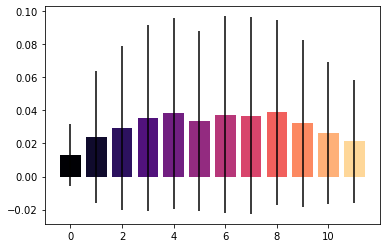

In [3]:
mean = np.mean(corr_dict['test_cc_raw'], axis=1)
std = np.std(corr_dict['test_cc_raw'], axis=1)

import matplotlib.cm as cm
cmap = cm.get_cmap('magma')
colors = cmap(np.arange(mean.shape[0])/mean.shape[0])
plt.bar(x=np.arange(mean.shape[0]), height=mean, yerr=std, color=colors)
# plt.ylim([0, 0.7])
